In [1]:
from funciones import *

In [7]:
fecha(9,12,2021)

{'dias_faltantes': 191,
 'fecha_date': datetime.date(2021, 12, 9),
 'fecha_datetime': datetime.datetime(2021, 12, 9, 0, 0),
 'fecha_ISO': '2021-12-09',
 'fecha_timestamp': 1639018800.0,
 'fecha_TXT': 'Jueves 9 de diciembre de 2021'}

# Imports

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# Funciones

In [9]:
def getData(ticker, start=None, end=None, src='yahoo'):
    """
    Parameters:
        ticker (str): Es el ticker a descargar
        
    Return:
        Devuelve un dataframe con las columnas "open" ....
        
    """
    if src == 'yahoo':
        data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
        data['vol_mln'] = data.Volume * data.Close / 10**6
        data['chg'] = data.Close.pct_change()
        data.columns = ['open', 'high', 'low', 'close', 'vol_n', 'vol_mln', 'pct_change']
                
    else:
        data = pd.DataFrame()
        
    
    return data

In [11]:
def addSignal(data, fast=5, slow=20, rsi_q=14, buy_cr=0, buy_rsi=60, sell_cr=0, sell_rsi=35):
    """
    Ya asumo que el dataframe data viene con la columna 'close'
    """
    
    data['Cruce'] = (data.close.rolling(fast).mean() /
                     data.close.rolling(slow).mean() - 1) * 100

    dif = data['close'].diff()
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1 / rsi_q).mean()
    ema_loss = loss.ewm(alpha=1 / rsi_q).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index
    data['rsi'] = rsi

    data['signal'] = 'Sin Señal'
    comprar = (data.Cruce > buy_cr) & (data.rsi > buy_rsi)
    data.loc[comprar, 'signal'] = 'Compra'

    vender = (data.Cruce < sell_cr) & (data.rsi < sell_rsi) 
    data.loc[vender, 'signal'] = 'Venta'

    return data

In [ ]:
# BUG 

In [14]:
def getActions(data, tipo='long'):
    """
    Estoy asumiendo que el dataframe data tiene una columna que se llama Signal que tiene Compra, Venta o Sin Señal
    """
    actions = data.loc[data.signal != 'Sin Señal'].copy()
    actions['signal'] = np.where(actions.signal != actions.signal.shift(), actions.signal,'Sin Señal')
    actions = actions.loc[actions.signal != 'Sin Señal'].copy()

    # Este if es para que empiece comprado y termine vendiendo si es Long  o viceversa si es short
    if len(actions) > 2:
        if tipo == 'long':
            if actions.iloc[0].loc['signal'] == 'Venta':
                actions = actions.iloc[1:]

            if actions.iloc[-1].loc['signal'] == 'Compra':
                actions = actions.iloc[:-1]

        elif tipo == 'short':
            if actions.iloc[0].loc['signal'] == 'Compra':
                actions = actions.iloc[1:]

            if actions.iloc[-1].loc['signal'] == 'Venta':
                actions = actions.iloc[:-1]
                
        else:
            print(f'Chouzeadas no permitidas: Solo tipo long o short, ingresaste {tipo}')
            actions = None

    return actions

In [23]:
def getTrades(actions, tipo='long', CT=0):
    """
    El CT es una cte con el costo transaccional que incluye:
        - comision de la compra  0.03
        - comision de la venta  0.03 (si es ...)
        - comision del prestamo si es short
        - derechos de mercado en compra
        - derechos de mercado en venta 
        - spread bid/ask
    """
    
    try:
        pares = actions.iloc[::2].loc[:,['close']].reset_index()
        impares = actions.iloc[1::2].loc[:,['close']].reset_index()
        trades = pd.concat([pares, impares], axis=1)
        
        if tipo=='long':
            trades.columns = ['fecha_compra','px_compra','fecha_venta','px_venta']
            trades['rendimiento'] = trades.px_venta / trades.px_compra - 1
            #trades['rendimiento'] -= CT
            
            trades['days'] = (trades.fecha_venta - trades.fecha_compra).dt.days

        elif tipo=='short':
            trades.columns = ['fecha_venta','px_venta', 'fecha_compra','px_compra']
            trades['rendimiento'] = 1- trades.px_compra / trades.px_venta
            trades['days'] = (trades.fecha_compra - trades.fecha_venta).dt.days

        else:
            trades = []
            print(f'Chouzeadas no permitidas: Solo tipo long o short, ingresaste {tipo}')

        if len(trades):
            trades['resultado'] = np.where(trades['rendimiento'] > 0 , 'Ganador' , 'Perdedor')
            trades['rendimientoAcumulado'] = (trades['rendimiento']+1).cumprod()

    except:
        print('Fallo en el ingreso de tabla de acciones')
        trades = []
        
    return trades

In [26]:
def resumen(trades):
    
    if len(trades):
        resultado = float(trades.iloc[-1:].rendimientoAcumulado-1)
        agg_cantidades = trades.groupby('resultado').size()
        agg_rendimientos = trades.groupby('resultado').mean()['rendimiento']
        agg_tiempos = trades.groupby('resultado').sum()['days']
        agg_tiempos_medio = trades.groupby('resultado').mean()['days']

        r = pd.concat([agg_cantidades,agg_rendimientos, agg_tiempos, agg_tiempos_medio ], axis=1)
        r.columns = ['Cantidad', 'Rendimiento x Trade', 'Dias Total', 'Dias x Trade']
        resumen = r.T
        
        try:
            t_win = r['Dias Total']['Ganador'] 
        except:
            t_win = 0
            
        try:
            t_loss = r['Dias Total']['Perdedor']
        except:
            t_loss = 0

        t = t_win + t_loss
        tea = (resultado +1)**(365/t)-1 if t > 0 else 0
        
        metricas = {'rendimiento':round(resultado,4), 'dias_in':round(t,4), 'TEA':round(tea,4)}
    else:
        resumen = pd.DataFrame()
        metricas = {'rendimiento':0, 'dias_in':0, 'TEA':0}
        
    return resumen, metricas

In [29]:
def eventDrivenLong(df):
    '''
    El dataframe que le pasas como argumento tiene que tener al menos las columnas:
        - signal: Compra o Venta el dia que da señal al precio de cierre 
        - pct_change: La variacion porcentual de los precios de cierre cada dia
        
    La funcion devuelve un df igual al pasado como argumento pero agregando la columna <strategy> 
        Dicha columna tiene 0 o el valor de pct_change
        Para saber si un dia se está comprado o no, se toma la señal del dia anterior (precios de cierre)
    '''
    signals = df['signal'].tolist()
    pct_changes = df['pct_change'].tolist()

    total = len(signals)
    i = 1
    results = [0]
    
    while i < total:

        if signals[i-1] == 'Compra' :

            j = i
            while  j < total:
                results.append(pct_changes[j])         
                j +=1

                if signals[j-1]=='Venta'  :
                    i = j
                    break
                if j == total:
                    i = j
                    print('Ojo que queda compra abierta..')
                    break
        else:
            results.append(0)
            i +=1

    result = pd.concat ([df,pd.Series(data=results, index=df.index)], axis=1)
    result.columns.values[-1] = "strategy"
    return result

## Uso de todo esto

In [30]:
data = getData('AAPL')

In [33]:
%%time
df = addSignal(data, fast=20, slow=60, rsi_q=14, buy_cr=5, buy_rsi=75, sell_cr=0, sell_rsi=35).dropna()
actions = getActions(df, tipo='long')
trades = getTrades(actions,  tipo='long')
r, metricas = resumen(trades)
final = eventDrivenLong(df)

print(r, '\n\n',metricas)

resultado                Ganador    Perdedor
Cantidad               18.000000    9.000000
Rendimiento x Trade     0.585423   -0.143319
Dias Total           5601.000000  747.000000
Dias x Trade          311.166667   83.000000 

 {'rendimiento': 272.0055, 'dias_in': 6348, 'TEA': 0.3806}
Wall time: 43.5 ms


In [34]:
final

,open,high,low,close,vol_n,vol_mln,pct_change,Cruce,rsi,signal,strategy
Date,,,,,,,,,,,
1981-03-10,0.079286,0.079286,0.078848,0.078848,28380800,2.237776,-0.047625,-11.876356,30.729464,Venta,0.0
1981-03-11,0.076658,0.076658,0.075782,0.075782,29859200,2.262792,-0.038887,-12.488295,28.266326,Venta,0.0
1981-03-12,0.078848,0.079286,0.078848,0.078848,59248000,4.671601,0.040460,-12.920791,33.966436,Venta,0.0
1981-03-13,0.078410,0.078410,0.077972,0.077972,231302400,18.035160,-0.011110,-13.443598,33.155788,Venta,0.0
1981-03-16,0.081039,0.081915,0.081039,0.081039,37228800,3.016990,0.039333,-13.719255,38.673904,Sin Señal,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,127.820000,128.320007,126.320000,126.900002,72009500,9138.005660,-0.001574,0.995310,48.077877,Sin Señal,0.0
2021-05-26,126.959999,127.389999,126.419998,126.849998,56575900,7176.652829,-0.000394,0.712564,47.961159,Sin Señal,0.0
2021-05-27,126.440002,127.639999,125.080002,125.279999,94625600,11854.695052,-0.012377,0.352284,44.322787,Sin Señal,0.0


<AxesSubplot:xlabel='Date'>

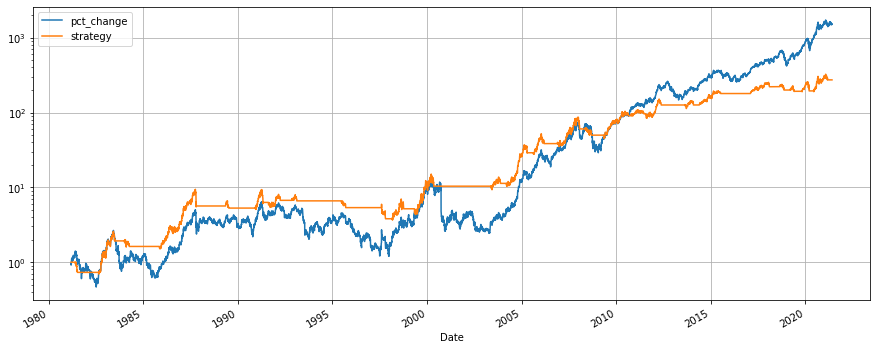

In [10]:
# Preparo base 100 de HODL y estrategia
res_buyHold = (final['pct_change']+1).cumprod()
res_st = (final['strategy']+1).cumprod()

# Concateno ambos
compare = pd.concat([res_buyHold, res_st], axis=1)

# Ploteo
compare.plot(figsize=(15,6), logy=True, grid=True)

<AxesSubplot:xlabel='Date'>

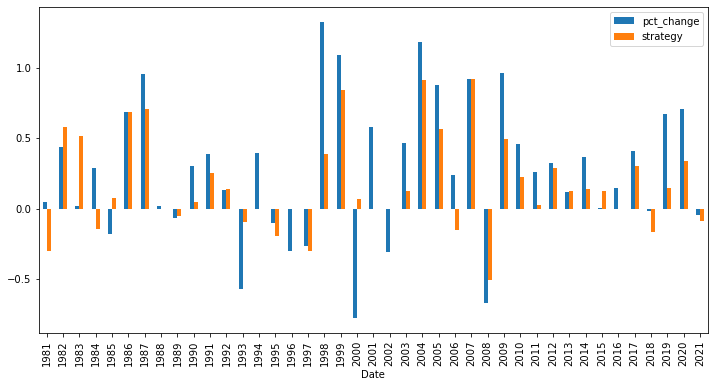

In [11]:
yoy = final.loc[: , ['pct_change','strategy']].groupby(final.index.year).sum()

yoy.plot(figsize=(12,6), kind='bar')

# EventDriven style: TIPS

## Iteracion: Formas y Performances

In [35]:
# numba

In [12]:
data = yf.download('AAPL', auto_adjust=True)
iterable_df = data
iterable_serie = data['Close']
iterable_np = np.array(data['Close'].tolist())
iterable_lista = data['Close'].to_list()
iterable_tupla = tuple(iterable_lista)

[*********************100%***********************]  1 of 1 completed


### Formas

In [13]:
for i, (idx, row) in enumerate(iterable_df.iterrows()):
    if i==5:
        print(row.Close)

0.09899868816137314


In [14]:
for i, row in enumerate(iterable_serie):
    if i==5:
        print(row)

0.09899868816137314


In [15]:
for i, row in enumerate(iterable_np):
    if i==5:
        print(row)

0.09899868816137314


In [16]:
for i in range(len(iterable_np)):
    if i==5:
        print(iterable_np[i])

0.09899868816137314


In [17]:
for i, row in enumerate(iterable_lista):
    if i==5:
        print(row)

0.09899868816137314


In [18]:
for i in range(len(iterable_lista)):
    if i==5:
        print(iterable_lista[i])

0.09899868816137314


In [19]:
for i, row in enumerate(iterable_tupla):
    if i==5:
        print(row)

0.09899868816137314


In [20]:
for i in range(len(iterable_tupla)):
    if i==5:
        print(iterable_tupla[i])

0.09899868816137314


### Performances

#### Con Enumerate e Iterando los objetos

In [21]:
%%timeit
for i, (idx, row) in enumerate(iterable_df.iterrows()):
    if i==5:
        a = row.Close

320 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
for i, row in enumerate(iterable_serie):
    if i==5:
        a = row

1.23 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%%timeit
for i, row in enumerate(iterable_np):
    if i==5:
        a = row

1.16 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit
for i, row in enumerate(iterable_lista):
    if i==5:
        a = row

559 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%%timeit
for i, row in enumerate(iterable_tupla):
    if i==5:
        a = row

559 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Con range y accediendo por afuera a los objetos

In [26]:
%%timeit
for i in range(len(iterable_df)):
    if i==5:
        a = iterable_df.iloc[i]

487 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%%timeit
for i in range(len(iterable_serie)):
    if i==5:
        a = iterable_serie.iloc[i]

395 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%%timeit
for i in range(len(iterable_np)):
    if i==5:
        a = iterable_np[i]

363 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
%%timeit
for i in range(len(iterable_lista)):
    if i==5:
        a= iterable_lista[i]

379 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%%timeit
for i in range(len(iterable_tupla)):
    if i==5:
        a= iterable_tupla[i]

371 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Event-Driven Por que While y no FOR?

In [26]:
for i in range(10):
    print(i)
    if i==5:
        i=9

0
1
2
3
4
5
6
7
8
9


In [37]:
i = 0

while i < 15:
    print(i)
    
    if i==5:
        i=9
    
    i +=1

0
1
2
3
4
5
10
11
12
13
14


## Para probar en pythontutor

In [30]:
signals = ['-','-','Compra','-','-','Venta','-','-','Compra','-']
pct_changes = [1,2,3,4,5,6,7,8,9,10]

total = 10
i = 1
results = [0]

while i < total:

    if signals[i-1] == 'Compra':

        j = i
        while  j < total:
            results.append(pct_changes[j])            
            j +=1

            if signals[j-1]=='Venta':
                i = j
                break
            if j == total:
                i = j
                print('Ojo que queda compra abierta..')
                break
    else:
        results.append(0)
        i +=1

results, len(results)

Ojo que queda compra abierta..


([0, 0, 0, 4, 5, 6, 0, 0, 0, 10], 10)

# Analisis de sensibilidad básico

## Sensibilidad del "q" del RSI

In [38]:
data = getData('AMZN')
results = []

for i_rsi in range(5,50):

    df = addSignal(data, fast=20, slow=60, rsi_q= i_rsi , buy_cr=2, buy_rsi=65, sell_cr=0, sell_rsi=35).dropna()
    actions = getActions(df, tipo='long')
    trades = getTrades(actions,  tipo='long')
    r, metricas = resumen(trades)
    
    results.append(metricas)
    
df = pd.DataFrame(results, index=range(5,50))

In [41]:
df.loc[df.dias_in>0].loc[15:25]

,rendimiento,dias_in,TEA
15,272.5061,5854.0,0.4189
16,166.9593,5807.0,0.3800
17,205.3993,6038.0,0.3801
18,180.7545,5247.0,0.4361
19,90.1475,5122.0,0.3793
20,266.3201,5260.0,0.4737
21,253.6410,5123.0,0.4839
22,237.3526,5277.0,0.4603
23,344.0116,5436.0,0.4805
24,405.9670,5542.0,0.4855


In [42]:
df.idxmax()

rendimiento    24
dias_in        17
TEA            24
dtype: int64

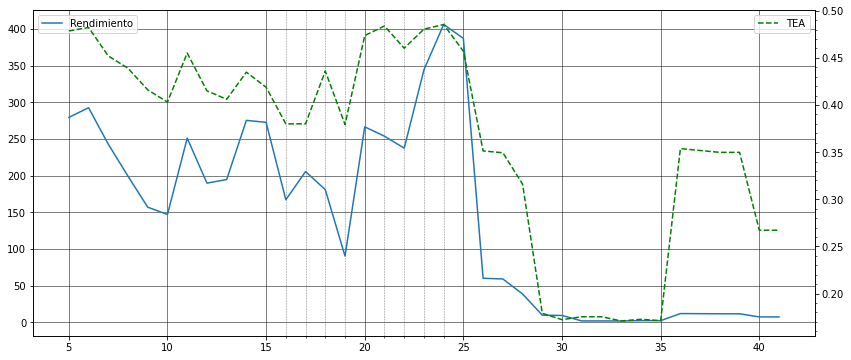

In [34]:
import matplotlib.pyplot as plt

dfok = df.loc[df.dias_in>0].copy()

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(dfok.rendimiento, label='Rendimiento')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfok.TEA, 'g--', label='TEA')
ax2.legend(loc='upper right')

plt.minorticks_on()
ax.set_xticks(np.arange(15,25,1),minor=True)
ax.grid(which='major', axis='both', color='k', lw=0.5, linestyle='-')
ax.grid(which='minor', color='gray', lw=0.5, linestyle='--')

## Sensibilidad del RSI señal compra

In [46]:
data = getData('AAPL')
results = []

for i in range(25,75):
    df = addSignal(data, fast=20, slow=60, rsi_q=24, buy_cr=2, buy_rsi=i, sell_cr=0, sell_rsi=35).dropna()
    actions = getActions(df, tipo='long')
    trades = getTrades(actions,  tipo='long')
    r, metricas = resumen(trades)
    
    results.append(metricas)
    
df = pd.DataFrame(results, index=range(25,75))

In [47]:
df.loc[df.dias_in>0].idxmax()

rendimiento    55
dias_in        25
TEA            70
dtype: int64

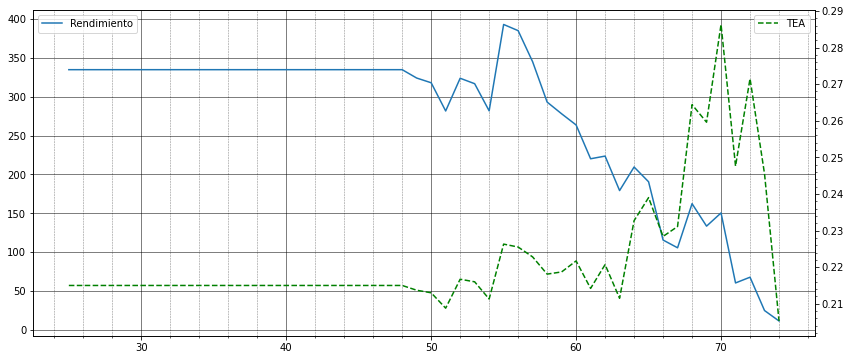

In [48]:
import matplotlib.pyplot as plt

dfok = df.loc[df.dias_in>0].copy()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(dfok.rendimiento, label='Rendimiento')
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(dfok.TEA, 'g--', label='TEA')
ax2.legend(loc='upper right')

plt.minorticks_on()
ax.grid(which='major', axis='both', color='k', lw=0.5, linestyle='-')
ax.grid(which='minor', color='gray', lw=0.5, linestyle='--')

## Sensibilidad por montecarlo multivariable

In [50]:
import random

In [39]:
random_f = random.randrange(5,100)
random_s = int(random_f * (random.random()+1))+1

#random_s = random.randrange(random_f+1,150)
random_f, random_s

(39, 64)

In [40]:
data = getData('AAPL')

In [51]:
%%time

results = []
for i in range(1000):
    random_f = random.randrange(35,50)
    random_s = int(random_f * (random.random()+1))+1
    random_rsi = random.randrange(10,30)

    df = addSignal(data, fast=random_f, slow=random_s, rsi_q=random_rsi, buy_cr=2, buy_rsi=68, sell_cr=0, sell_rsi=35).dropna()
    actions = getActions(df, tipo='long')
    trades = getTrades(actions,  tipo='long')
    r, metricas = resumen(trades)
                
    res = {
        'fast':random_f, 'slow':random_s, 'rsi_q':random_rsi, 
         'cant_trades':len(trades), 'dias_in':metricas['dias_in'], 
         'TEA':metricas['TEA'], 'rendimiento':metricas['rendimiento']  
        }
    
    results.append(res)
    print(f"Test {i}/1000  --  {random_f}_{random_s}_{random_rsi}      ", end='\r')
    
df = pd.DataFrame(results)
df

Wall time: 28.8 s  43_81_27      


,fast,slow,rsi_q,cant_trades,dias_in,TEA,rendimiento
0,48,80,29,9,7552.0,0.3500,496.6638
1,40,63,20,18,8015.0,0.2928,280.0891
2,47,50,18,1,807.0,0.7175,2.3062
3,46,85,26,11,8221.0,0.3311,626.2290
4,39,71,21,16,8416.0,0.3045,458.2666
...,...,...,...,...,...,...,...
995,42,49,21,10,4516.0,0.3476,39.0910
996,46,73,14,25,8051.0,0.2216,81.7360
997,44,63,28,10,7116.0,0.3534,364.2274
998,36,68,13,35,8094.0,0.1871,43.8936


In [52]:
df.loc[df.cant_trades > 10].sort_values('rendimiento', ascending=False)

,fast,slow,rsi_q,cant_trades,dias_in,TEA,rendimiento
901,42,52,16,18,7288.0,0.4487,1636.0185
333,42,54,16,19,7319.0,0.4451,1607.5496
543,43,51,17,13,6078.0,0.5555,1565.6311
895,42,59,18,15,7790.0,0.4051,1420.3462
162,39,53,19,15,7216.0,0.4416,1379.6645
...,...,...,...,...,...,...,...
76,43,82,10,38,8602.0,0.1388,20.4070
868,43,82,10,38,8602.0,0.1388,20.4070
364,38,69,11,38,8219.0,0.1405,18.3151
521,46,82,11,35,8568.0,0.1298,16.5608


# Analisis de Portabilidad Básico

In [53]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e.replace('.','-') for e in sp500_tickers]
data_sp500 = yf.download(sp500_tickers, start='1980-01-01')['Adj Close']

[*********************100%***********************]  505 of 505 completed


In [56]:
pd.options.display.max_columns=10
data_sp500['AAPL']

Date
1980-01-02           NaN
1980-01-03           NaN
1980-01-04           NaN
1980-01-07           NaN
1980-01-08           NaN
                 ...    
2021-05-25    126.900002
2021-05-26    126.849998
2021-05-27    125.279999
2021-05-28    124.610001
2021-06-01    124.279999
Name: AAPL, Length: 10454, dtype: float64

In [57]:
%time

results = []
for ticker in sp500_tickers[:]:
    try:
        
        data = pd.DataFrame(data_sp500[ticker].copy())
        data.columns=['close']
        
        df = addSignal(data, fast=40, slow=52, rsi_q=17, buy_cr=2, buy_rsi=68, sell_cr=0, sell_rsi=35).dropna()
        actions = getActions(df, tipo='long')
        trades = getTrades(actions,  tipo='long')
        r, metricas = resumen(trades)
        metricas['ticker'] = ticker
        results.append(metricas)

        print(ticker, end='..')
    except:
        s = "\n"+ "*"*50 + "\n"
        print(s,"Error con",ticker,s)

results_df = pd.DataFrame(results)
results_df

Wall time: 0 ns
MMM..ABT..ABBV..ABMD..ACN..ATVI..ADBE..AMD..AAP..AES..AFL..A..APD..AKAM..ALK..ALB..ARE..ALXN..ALGN..ALLE..LNT..ALL..GOOGL..GOOG..MO..AMZN..AMCR..AEE..AAL..AEP..AXP..AIG..AMT..AWK..AMP..ABC..AME..AMGN..APH..ADI..ANSS..ANTM..AON..AOS..APA..AAPL..AMAT..APTV..ADM..ANET..AJG..AIZ..T..ATO..ADSK..ADP..AZO..AVB..AVY..BKR..BLL..BAC..BK..BAX..BDX..BRK-B..BBY..BIO..BIIB..BLK..BA..BKNG..BWA..BXP..BSX..BMY..AVGO..BR..BF-B..CHRW..COG..CDNS..CZR..CPB..COF..CAH..KMX..CCL..CARR..CTLT..CAT..CBOE..CBRE..CDW..CE..CNC..CNP..CERN..CF..CRL..SCHW..CHTR..CVX..CMG..CB..CHD..CI..CINF..CTAS..CSCO..C..CFG..CTXS..CLX..CME..CMS..KO..CTSH..CL..CMCSA..CMA..CAG..COP..ED..STZ..COO..CPRT..GLW..CTVA..COST..CCI..CSX..CMI..CVS..DHI..DHR..DRI..DVA..DE..DAL..XRAY..DVN..DXCM..FANG..DLR..DFS..DISCA..DISCK..DISH..DG..DLTR..D..DPZ..DOV..DOW..DTE..DUK..DRE..DD..DXC..EMN..ETN..EBAY..ECL..EIX..EW..EA..EMR..ENPH..ETR..EOG..EFX..EQIX..EQR..ESS..EL..ETSY..EVRG..ES..RE..EXC..EXPE..EXPD..EXR..XOM..FFIV..FB..FAST..FRT..FDX

,rendimiento,dias_in,TEA,ticker
0,0.5401,2458.0,0.0662,MMM
1,3.5849,4696.0,0.1256,ABT
2,-0.2473,498.0,-0.1880,ABBV
3,0.1783,5948.0,0.0101,ABMD
4,1.1331,3065.0,0.0944,ACN
...,...,...,...,...
500,1.5184,2678.0,0.1342,YUM
501,4.1059,3922.0,0.1638,ZBRA
502,0.9083,2380.0,0.1042,ZBH
503,0.2723,6414.0,0.0138,ZION


In [58]:
results_df.loc[results_df.dias_in > 0].sort_values('dias_in', ascending=False).head(10)

,rendimiento,dias_in,TEA,ticker
45,4797.6540,8048.0,0.4688,AAPL
461,415.9278,7837.0,0.3244,UNH
459,229.7175,7377.0,0.3089,UNP
489,37.8029,7105.0,0.2068,WDC
60,83.3147,7038.0,0.2586,BLL
46,391.8703,6918.0,0.3705,AMAT
54,1.8380,6895.0,0.0568,ADSK
402,171.6355,6887.0,0.3139,RHI
196,2.4087,6674.0,0.0694,FMC
426,15.3746,6656.0,0.1657,SYK


<AxesSubplot:>

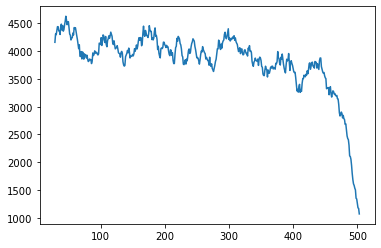

In [59]:
re = results_df.loc[results_df.dias_in > 0].sort_values('TEA', ascending=False)

re.dias_in.reset_index().rolling(30).mean().dias_in.plot()

In [60]:
re

,rendimiento,dias_in,TEA,ticker
168,48.7631,1690.0,1.3254,ENPH
176,8.3542,1364.0,0.8190,ETSY
456,3485.5087,5691.0,0.6873,USB
331,88.0379,3842.0,0.5318,NFLX
410,224.7577,4995.0,0.4859,SBAC
...,...,...,...,...
154,-0.0934,81.0,-0.3571,DOW
363,-0.1249,93.0,-0.4077,PYPL
201,-0.1495,77.0,-0.5359,FOXA
202,-0.1532,78.0,-0.5408,FOX


<AxesSubplot:ylabel='Frequency'>

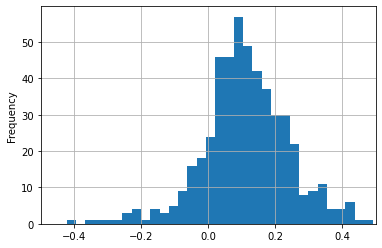

In [58]:
resok = results_df.dropna()
resok['TEA'].plot(kind='hist', bins=100, xlim=(-.5,.5), grid=True)

<AxesSubplot:ylabel='Density'>

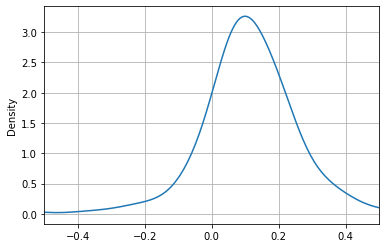

In [60]:
resok['TEA'].plot(kind='kde', xlim=(-.5,.5), grid=True)

In [69]:
re.TEA.mean()

0.11657638888888874